In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from poker_utils.model import (
    prob_embeddings, 
    analyze_embeddings, 
    evaluate_hand_hand_equity, 
    save_model_and_embeddings
)

In [3]:
base_data = pd.read_csv("data/raw/base_hand_data.csv").set_index("hand")
blocker_data = pd.read_csv("data/raw/preflop_block_data.csv").set_index('hand')
ev_data = pd.read_csv('data/raw/ev_pca_data.csv').set_index('hand').filter(regex="play")
equity_data = pd.read_csv("data/processed/equity_totals.csv").set_index("hand")
equity_matrix = pd.read_csv("data/processed/equity_matrix.csv")


In [4]:
full_data = pd.concat(
    [base_data, 
     blocker_data, 
     equity_data, 
     ev_data], axis=1)

In [5]:
cols = [
    'suited', 'connectedness', 'pair', 'high_card', 'low_card',
    'rank_diff', 'ace', 'broadway', 'low_pair', 'medium_pair',
    'high_pair', 'broadway_score', 'suited_broadway',
    'suited_broadway_score', 'connector', 'one_gap', 'two_gap',
    'suited_connector', 'suited_one_gap', 'suited_two_gap',
    'connectedness_score', 'rank_diff_score', 'high_card_score',
    'low_card_score', 'suited_connected_score',
       
    'block_aa', 'block_kk', 'block_qq', 'block_ak', 'block_aq',
    'prem_blocker_score', 'prem_blocker_score_norm', 'block_aa_score',
    'block_kk_score',
       
    'tot_win_perc', 'high_card_win_perc',
    'one_pair_win_perc', 'two_pair_win_perc', 'three_of_a_kind_win_perc',
    'straight_win_perc', 'flush_win_perc', 'full_house_win_perc',
    'four_of_a_kind_win_perc', 'straight_flush_win_perc',
    'straight_win_potential', 'flush_win_potential', 'value_win_potential',
    'highcard_win_potential',
       
    'BB_play10', 'BB_play2', 'BB_play3', 'BB_play4', 'BB_play5', 'BB_play6',
    'BB_play7', 'BB_play8', 'BB_play9', 'D_play10', 'D_play3', 'D_play4',
    'D_play5', 'D_play6', 'D_play7', 'D_play8', 'D_play9', 'SB_play10',
    'SB_play2', 'SB_play3', 'SB_play4', 'SB_play5', 'SB_play6', 'SB_play7',
    'SB_play8', 'SB_play9', 'pos3_play10', 'pos3_play4', 'pos3_play5',
    'pos3_play6', 'pos3_play7', 'pos3_play8', 'pos3_play9', 'pos4_play10',
    'pos4_play5', 'pos4_play6', 'pos4_play7', 'pos4_play8', 'pos4_play9',
    'pos5_play10', 'pos5_play6', 'pos5_play7', 'pos5_play8', 'pos5_play9',
    'pos6_play10', 'pos6_play7', 'pos6_play8', 'pos6_play9', 'pos7_play10',
    'pos7_play8', 'pos7_play9', 'pos8_play10', 'pos8_play9', 'pos9_play10'
]

In [6]:
scaler = StandardScaler()

In [7]:
X = np.concat([full_data[cols].to_numpy(), equity_matrix.set_index("hand").to_numpy()],axis=1)
X_scaled = scaler.fit_transform(X)

In [8]:
pca = PCA(n_components=128)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
X_pca_norm = normalize(X_pca, norm='l2')

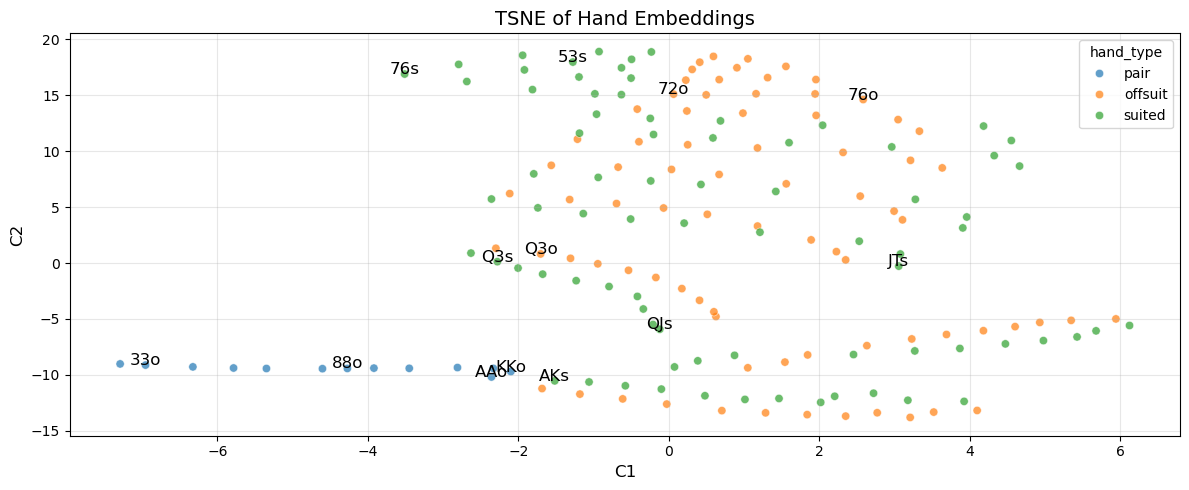

   hand         top_1         top_2         top_3       bottom_1  \
0   AAo  KKo (0.9658)  QQo (0.9292)  AKs (0.8703)  94s (-0.5745)   
1   KKo  AAo (0.9658)  QQo (0.9599)  JJo (0.9186)  92s (-0.6365)   
2   72o  62o (0.9534)  72s (0.9433)  82o (0.9433)  JJo (-0.7270)   
3   76s  65s (0.8445)  87s (0.7880)  76o (0.7855)  K9o (-0.5366)   
4   76o  75o (0.8804)  65o (0.8661)  86o (0.8390)  A9s (-0.6688)   
5   Q3s  Q3o (0.8430)  Q4s (0.7676)  Q2s (0.7524)  AAo (-0.2879)   
6   Q3o  Q3s (0.8430)  Q4o (0.7882)  Q2o (0.7853)  KKo (-0.4458)   
7   88o  99o (0.9596)  77o (0.9520)  TTo (0.9009)  52o (-0.7209)   
8   JTs  QJs (0.7514)  JTo (0.7204)  J9s (0.7191)  72o (-0.6323)   
9   33o  44o (0.8729)  22o (0.8582)  55o (0.7242)  Q4o (-0.2797)   
10  AKs  AKo (0.9422)  AQs (0.9173)  AAo (0.8703)  94o (-0.6556)   
11  53s  42s (0.9252)  64s (0.9082)  53o (0.9024)  88o (-0.6291)   
12  QJs  QTs (0.8370)  QJo (0.7864)  KQs (0.7669)  83o (-0.7091)   

         bottom_2       bottom_3  
0   92s (-0.

In [9]:
similarity_df = analyze_embeddings(
    X_pca_norm, 
    hands_of_interest=['AAo','KKo','72o','76s','76o','Q3s',"Q3o",'88o','JTs','33o',"AKs","53s","QJs"],
    hand_feature_to_color='hand_type',
    figsize=(12,5)
    )

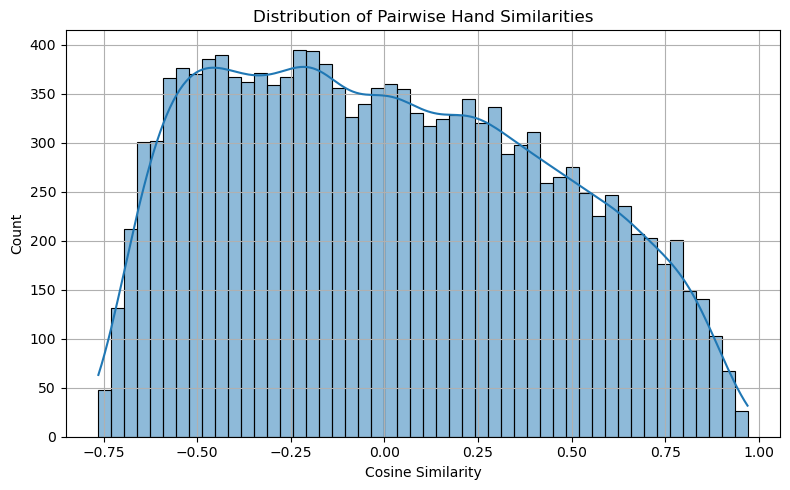

In [10]:
mask = np.triu(np.ones(similarity_df.shape), k=1).astype(bool)
pairwise_sims = similarity_df.where(mask)
all_similarities = pairwise_sims.stack().values

plt.figure(figsize=(8, 5))
sns.histplot(all_similarities, bins=50, kde=True)
plt.title("Distribution of Pairwise Hand Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
equity_matrix = equity_matrix.set_index('hand').to_numpy()

In [12]:
evaluate_hand_hand_equity(X_pca_norm, equity_matrix)


{'spear_corr': np.float64(0.6968852625274324), 'pval': np.float64(0.0)}

In [13]:
prob_data = pd.read_csv('data/processed/prob_data.csv')

In [14]:
prob_res = prob_embeddings(X_pca_norm, prob_data)

In [16]:
prob_res.sort_values(by='accuracy')

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
29,low_card,0,0.994083,1.0,1.0,1.0,0.147929,NaN
30,low_card,1,0.994083,1.0,1.0,1.0,0.136095,NaN
31,low_card,2,0.994083,1.0,1.0,1.0,0.124260,NaN
36,low_card,7,0.994083,1.0,1.0,1.0,0.065089,NaN
35,low_card,6,0.994083,1.0,1.0,1.0,0.076923,NaN
...,...,...,...,...,...,...,...,...
59,pos7_play8,NaN,NaN,NaN,NaN,NaN,NaN,0.146656
60,pos7_play9,NaN,NaN,NaN,NaN,NaN,NaN,0.151740
61,pos8_play10,NaN,NaN,NaN,NaN,NaN,NaN,0.153174
62,pos8_play9,NaN,NaN,NaN,NaN,NaN,NaN,0.151897


In [ ]:
# save_model_and_embeddings(
#     X_pca_norm,
#     "preflop_pca_embedding"
# )

In [ ]:
# prob_res.to_csv("results/prob_preflop_pca128.csv", index=False)
# similarity_df.reset_index().rename({"index":'hand'},axis=1).to_csv("results/sim_preflop_pca128.csv")